In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [6]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [7]:
# Pytorch like layers

In [8]:
class Linear:
    
    def __init__(self, gen, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=gen) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1D:
    
    def init(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable parameters
        self.gamma = torch.ones(dim)  # gain
        self.beta  = torch.zeros(dim) # bias
        # buffers (calculated with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar  = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar  = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # updating running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [11]:
g = torch.Generator().manual_seed(2147483647)

In [12]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [13]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [14]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [15]:
max_steps = 200000
batch_size = 32

In [16]:
lossi = []
losslog10i = []
stepsi = []

In [17]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
        
    break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.296154737472534


In [18]:
# Lets visualise what's going on with activations at all the tanh layers out

layer 1 (      Tanh): mean: -0.02, std: +0.75, saturated: +20.25%
layer 3 (      Tanh): mean: -0.00, std: +0.69, saturated: +8.38%
layer 5 (      Tanh): mean: +0.00, std: +0.67, saturated: +6.62%
layer 7 (      Tanh): mean: -0.01, std: +0.66, saturated: +5.47%
layer 9 (      Tanh): mean: -0.02, std: +0.66, saturated: +6.12%


Text(0.5, 1.0, 'Activation distribution')

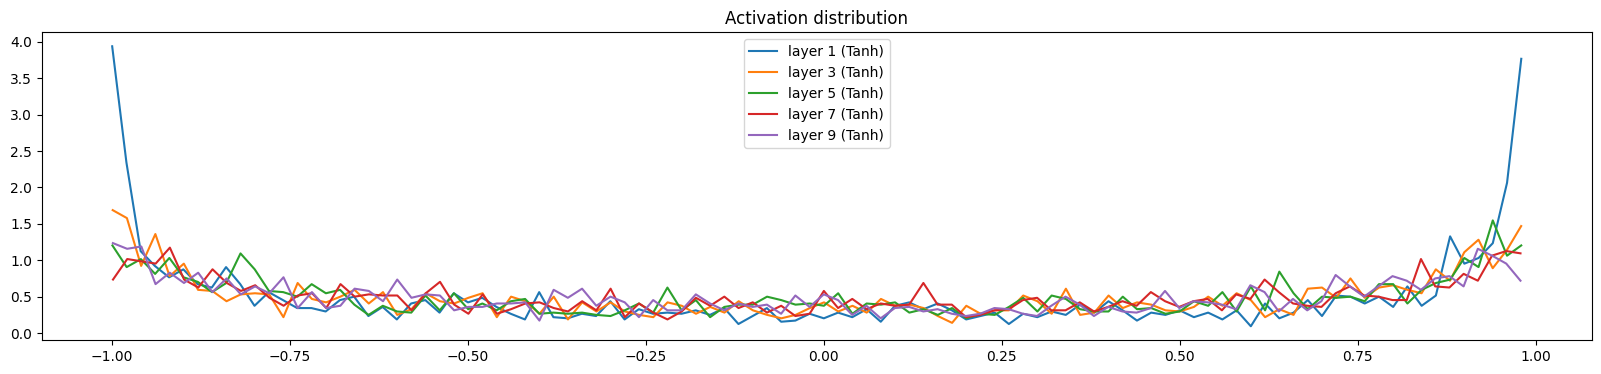

In [19]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

In [20]:
# First layer is fairly saturated
# following layers stabilizes a bit
# the reason it stablizes
# is because the gain is set to 5/3
# Lets try the same thing without gain

In [21]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [22]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #5/3

In [23]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [24]:
max_steps = 200000
batch_size = 32

In [25]:
lossi = []
losslog10i = []
stepsi = []

In [26]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
        
    break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.2963457107543945


In [27]:
# Lets visualise what's going on with activations at all the tanh layers out

layer 1 (      Tanh): mean: -0.00, std: +0.64, saturated: +4.19%
layer 3 (      Tanh): mean: +0.01, std: +0.48, saturated: +0.03%
layer 5 (      Tanh): mean: -0.00, std: +0.41, saturated: +0.00%
layer 7 (      Tanh): mean: +0.02, std: +0.35, saturated: +0.00%
layer 9 (      Tanh): mean: +0.00, std: +0.31, saturated: +0.00%


Text(0.5, 1.0, 'Activation distribution')

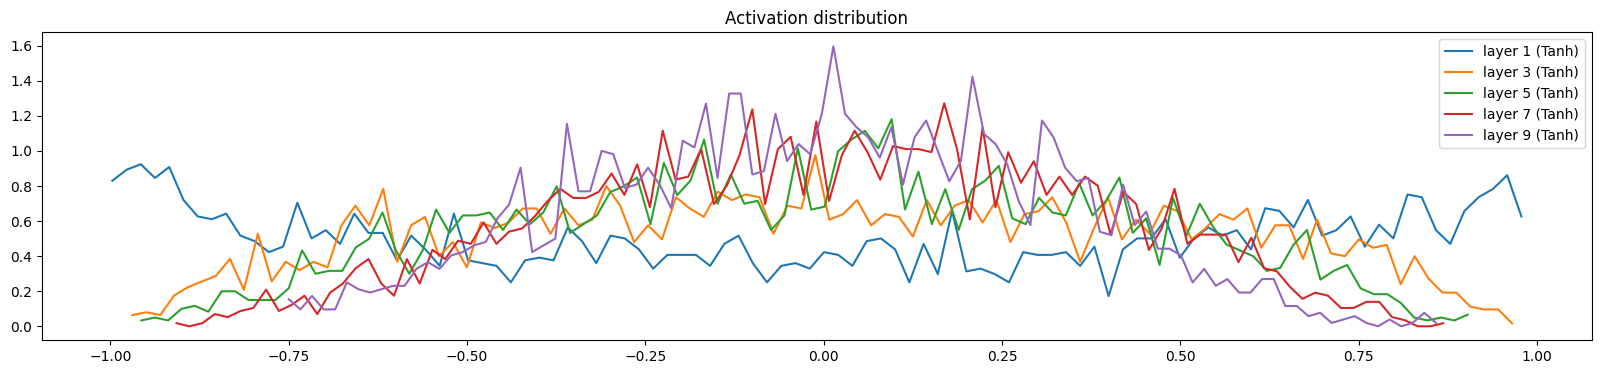

In [28]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

In [29]:
# We can see that
# std dev is shrinking and saturation is to zero
# first layer pretty decent, but
# further layers are converging to zero
# if we just had linear layers back to back then the weights would have stabilized
# but with the tanh layers interspersed, which are squashing functions
# over a bunch of layers, they keep getting further squashed as we can see above
# layer 9 is really squashed
# SO, some gain is necessary to fight the squashing
# Lets see what happens if the gain is too much

In [30]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [31]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3 #5/3

In [32]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [33]:
max_steps = 200000
batch_size = 32

In [34]:
lossi = []
losslog10i = []
stepsi = []

In [35]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
        
    break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.322606325149536


In [36]:
# Lets visualise what's going on with activations at all the tanh layers out

layer 1 (      Tanh): mean: +0.00, std: +0.87, saturated: +50.47%
layer 3 (      Tanh): mean: -0.01, std: +0.85, saturated: +44.00%
layer 5 (      Tanh): mean: +0.02, std: +0.85, saturated: +43.31%
layer 7 (      Tanh): mean: -0.00, std: +0.85, saturated: +43.41%
layer 9 (      Tanh): mean: -0.01, std: +0.83, saturated: +40.91%


Text(0.5, 1.0, 'Activation distribution')

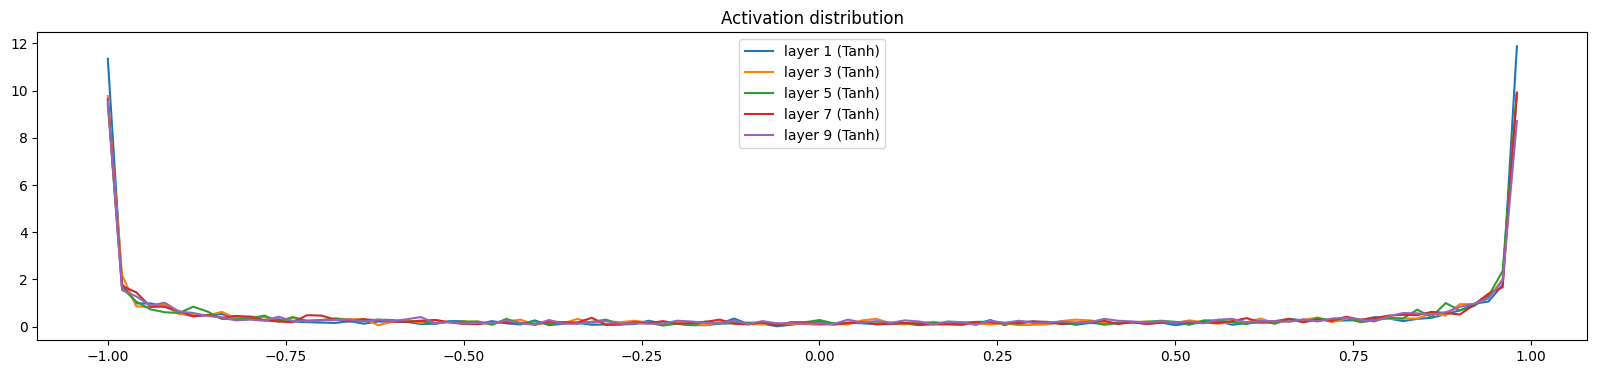

In [37]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

In [38]:
# And we can see that this gain is way to much
# almost everything is starting to get clamped
# tha saturations are very high

In [39]:
# The 5/3 gain in the tanh comes for the average value of tanh^2(x) where x is distributed as a Gaussian, i.e.
# integrate (tanh x)^2*exp(-x^2/2)/sqrt(2*pi) from -inf to inf ~= 0.39
# The square root of this value is how much the tanh squeezes 
# the variance of the incoming variable: 0.39 ** .5 ~= 0.63 ~= 3/5 (hence 5/3 is just an approximation of the exact gain).
# We then multiply by the gain to keep the output variance 1.

In [40]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [41]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [42]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [43]:
max_steps = 200000
batch_size = 32

In [44]:
lossi = []
losslog10i = []
stepsi = []

In [45]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
        
    break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.2819862365722656


In [46]:
# Lets visualise what's going on with activations at all the tanh layers out

layer 1 (      Tanh): mean: -0.03, std: +0.76, saturated: +20.81%
layer 3 (      Tanh): mean: +0.02, std: +0.68, saturated: +9.16%
layer 5 (      Tanh): mean: -0.01, std: +0.66, saturated: +5.56%
layer 7 (      Tanh): mean: -0.01, std: +0.66, saturated: +5.12%
layer 9 (      Tanh): mean: +0.01, std: +0.67, saturated: +6.75%


Text(0.5, 1.0, 'Activation distribution')

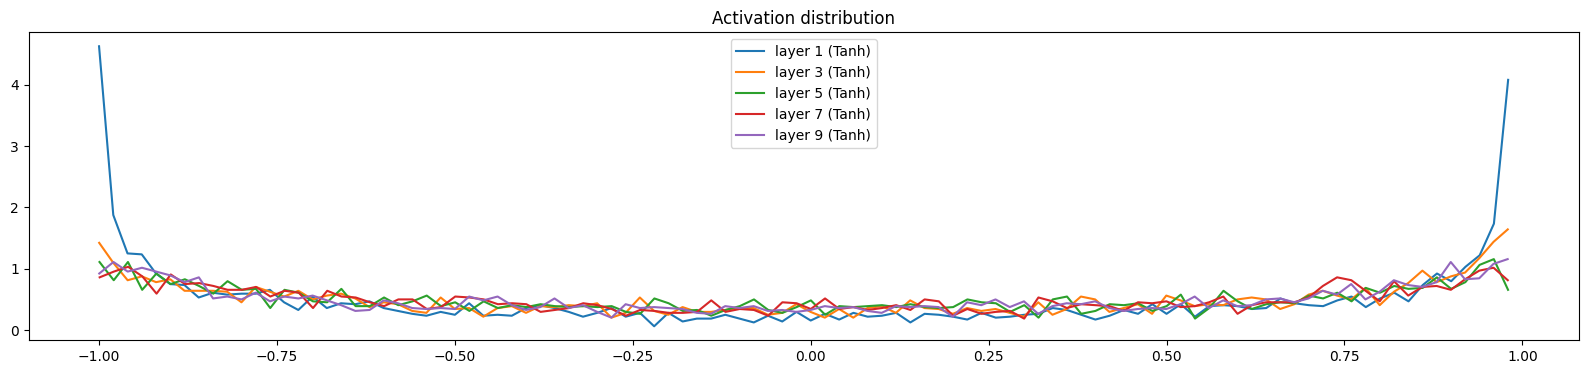

In [47]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

In [48]:
# 5/3 as gain for tanh roughly stabilizes the standard deviation and keeps the saturation to a low figure